# Day 5

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 역전파 신경망

In [2]:
import numpy as np

class Sigmoid:
    def __init__(self):
        self.y = None

    def __call__(self, x):
        return self.forward(x)

    def forward(self, x):
        y = 1 / (1 + np.exp(-x))
        self.y = y
        return y

    def backward(self, dout):
        dx = dout * self.y * (1 - self.y)
        return dx

class 완전연결:
    def __init__(self, 입력수, 출력수, 활성화=None):
        self.W = np.random.randn(입력수, 출력수)
        self.b = np.zeros(출력수)
        self.activation = 활성화
        self.x = None
        self.dW = None
        self.db = None

    def __call__(self, x):
        return self.forward(x)

    def forward(self, x):
        self.x = x
        z = np.dot(x, self.W) + self.b
        if self.activation:
            return self.activation(z)
        return z

    def backward(self, dout):
        if self.activation:
            dout = self.activation.backward(dout)
            
        self.dW = np.dot(self.x.T, dout)
        # 배치 단위 연산 시, 미분값을 모든 표본에 대해 더합니다.
        self.db = np.sum(dout, axis=0)
        
        dx = np.dot(dout, self.W.T)
        return dx

def softmax(z):
    if z.ndim == 1:
        z = z.reshape(1, -1)
    exp_z = np.exp(z - np.max(z, axis=1).reshape(-1, 1))
    return exp_z / np.sum(exp_z, axis=1).reshape(-1, 1)

def 교차엔트로피오차(y, y_pred):
    delta = 1e-7
    배치크기 = y.shape[0]
    return -np.sum(y * np.log(y_pred + delta)) / 배치크기

class CrossEntropy:
    def __init__(self, from_logits=False):
        self.y = None
        self.from_logits = from_logits
        self.proba = None

    def __call__(self, z, y):
        return self.forward(z, y)

    def forward(self, outputs, y):
        self.y = y
        # z -> softmax -> proba
        if not self.from_logits:      
            self.proba = outputs
        else: # from_logits=True -> 실수값 -> 확률값
            self.proba = softmax(outputs)
        # CEE(y, proba)
        손실 = 교차엔트로피오차(y, self.proba)
        return 손실

    def backward(self, dout=1):
        배치크기 = len(self.y)
        dz = self.proba - self.y
        return dz / 배치크기

class 역전파신경망:
    def __init__(self, 손실함수):
        self.layers = []
        self.loss_func = 손실함수

    def add(self, layer):
        self.layers.append(layer)

    def __call__(self, x):
        """순전파"""
        outputs = x
        for layer in self.layers:
            outputs = layer(outputs)
        return outputs # z_last

    def 손실산출(self, x, y):
        outputs = self(x)
        손실 = self.loss_func(outputs, y)
        return 손실

    def fit(self, x, y, 배치크기, 에폭수, 학습률):
        에폭당_배치수 = len(x) // 배치크기
        학습횟수 = 에폭당_배치수 * 에폭수
        print(f'배치크기={배치크기}, 에폭수={에폭수}, 학습횟수={학습횟수}({에폭당_배치수}/에폭)')
        손실변화 = []
        for 학습 in range(학습횟수):
            # 1. 미니 배치
            표본수 = S = len(x)
            배치색인 = np.random.choice(표본수, 배치크기)
            x_batch = x[배치색인]
            y_batch = y[배치색인]
            # 2. 경사 산출 (역전파)
            # 1) 순전파
            손실 = self.손실산출(x_batch, y_batch)
            손실변화.append(손실)
            # 2) 역전파            
            dout = self.loss_func.backward(1)
            for layer in reversed(self.layers):
                dout = layer.backward(dout)
            # 3. 매개변수 갱신 (경사 하강)
            for layer in self.layers:
                if isinstance(layer, 완전연결):
                    layer.W -= layer.dW * 학습률
                    layer.b -= layer.db * 학습률

            if 학습 == 0 or (학습 + 1) % 100 == 0:
                print(f'[학습 {학습 + 1}] Loss: {손실:.3f}')
        return 손실변화


## MNIST

In [3]:
from torchvision.datasets import MNIST

mnist = {}
mnist['train'] = MNIST(root='~/data', train=True, download=True)
mnist['test'] = MNIST(root='~/data', train=False, download=True)

In [4]:
def 전처리(images):
    if not isinstance(images, np.ndarray):
        images = np.array(images)
    X = images.astype(np.float32)
    X = X.reshape(-1, 28 * 28)
    X = X / 255.0
    return X

train_data = 전처리(mnist['train'].data)
train_target = np.array(mnist['train'].targets)
test_data = 전처리(mnist['test'].data)
test_target = np.array(mnist['test'].targets)
print(train_data.shape, test_data.shape)
assert np.isclose(train_data.max(), 1.0) and np.isclose(train_data.min(), 0.0)
assert np.isclose(test_data.max(), 1.0) and np.isclose(test_data.min(), 0.0)

(60000, 784) (10000, 784)


배치크기=100, 에폭수=10, 학습횟수=6000(600/에폭)
[학습 1] Loss: 8.757
[학습 100] Loss: 0.905
[학습 200] Loss: 0.602
[학습 300] Loss: 0.720
[학습 400] Loss: 0.527
[학습 500] Loss: 0.333
[학습 600] Loss: 0.416
[학습 700] Loss: 0.587
[학습 800] Loss: 0.539
[학습 900] Loss: 0.166
[학습 1000] Loss: 0.443
[학습 1100] Loss: 0.634
[학습 1200] Loss: 0.394
[학습 1300] Loss: 0.293
[학습 1400] Loss: 0.200
[학습 1500] Loss: 0.261
[학습 1600] Loss: 0.362
[학습 1700] Loss: 0.198
[학습 1800] Loss: 0.331
[학습 1900] Loss: 0.195
[학습 2000] Loss: 0.264
[학습 2100] Loss: 0.233
[학습 2200] Loss: 0.186
[학습 2300] Loss: 0.135
[학습 2400] Loss: 0.372
[학습 2500] Loss: 0.177
[학습 2600] Loss: 0.221
[학습 2700] Loss: 0.261
[학습 2800] Loss: 0.255
[학습 2900] Loss: 0.208
[학습 3000] Loss: 0.237
[학습 3100] Loss: 0.184
[학습 3200] Loss: 0.224
[학습 3300] Loss: 0.178
[학습 3400] Loss: 0.142
[학습 3500] Loss: 0.189
[학습 3600] Loss: 0.262
[학습 3700] Loss: 0.316
[학습 3800] Loss: 0.189
[학습 3900] Loss: 0.170
[학습 4000] Loss: 0.138
[학습 4100] Loss: 0.291
[학습 4200] Loss: 0.307
[학습 4300] Loss: 0.168
[학습 4400

<Axes: >

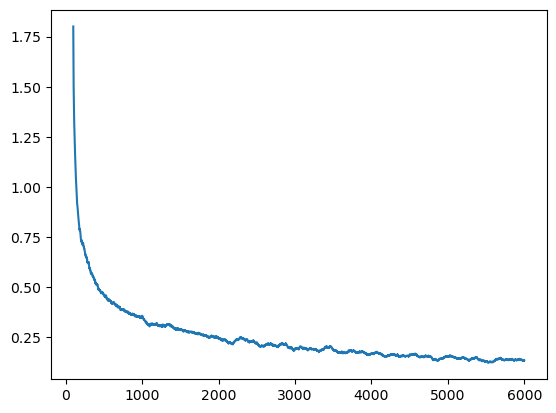

In [5]:
model = 역전파신경망(손실함수=CrossEntropy(from_logits=True))
model.add(완전연결(입력수=28*28, 출력수=50, 활성화=Sigmoid()))
model.add(완전연결(입력수=50, 출력수=100, 활성화=Sigmoid()))
model.add(완전연결(입력수=100, 출력수=10, 활성화=None))

원핫행렬 = np.eye(10)
loss_history = model.fit(train_data, 원핫행렬[train_target], 배치크기=100, 에폭수=10, 학습률=1.0)
# 평가
outputs = model(test_data)
y_pred = np.argmax(outputs, axis=1)
print(f'정확도: {np.mean(y_pred == test_target):.2%}')
# 손실 그래프
display(pd.Series(loss_history).rolling(window=100).mean().plot())

## PyTorch

PyTorch = NumPy + GPU + Backprop + ...

In [6]:
import torch

사과단가 = torch.tensor(100.0, requires_grad=True)
사과수량 = torch.tensor(2.0, requires_grad=True)
부가세 = torch.tensor(0.1)

사과가격 = 사과단가 * 사과수량 * (1 + 부가세)
사과가격.backward()

pd.DataFrame({
    '사과단가': [사과단가.item(), 사과단가.grad.item()],
    '사과수량': [사과수량.item(), 사과수량.grad.item()],
    '부가세': [부가세.item(), 부가세.grad]
}, index=['순전파', '역전파'])

,사과단가,사과수량,부가세
순전파,100.0,2.0,0.1
역전파,2.2,110.0,NaN


In [7]:
x = torch.tensor(1/3)
print(x) # 텐서 객체
print(f'{x.item():.2f}') # 파이썬 숫자형 값 (스칼라)

tensor(0.3333)
0.33


## 파이토치 신경망

In [12]:
import torch

class 다중퍼셉트론:
    def __init__(self, 입력수, 출력수, 활성화=None):
        self.W = torch.randn(입력수, 출력수, requires_grad=True)
        self.b = torch.zeros(출력수, requires_grad=True)
        self.활성화 = 활성화

    def __call__(self, x):
        z = torch.matmul(x, self.W) + self.b
        if self.활성화:
            z = self.활성화(z)
        return z
    
layer = 다중퍼셉트론(입력수=2, 출력수=3, 활성화=torch.sigmoid)
print(layer.W.shape, layer.b.shape)
assert layer.W.requires_grad and layer.b.requires_grad

X = torch.linspace(0, 1, 10).reshape(5, 2)
outputs = layer(X)


torch.Size([2, 3]) torch.Size([3])


In [ ]:
import torch.nn as nn # 신경망 모듈

layer = nn.Linear(in_features=2, out_features=3)
print(layer.weight.shape, layer.bias.shape)
assert layer.weight.requires_grad and layer.bias.requires_grad

X = torch.linspace(0, 1, 10).reshape(5, 2)
assert torch.allclose(layer(X), X @ layer.weight.T + layer.bias)
# 활성화 (직접 해야 합니다.)
Z = torch.sigmoid(layer(X))

torch.Size([3, 2]) torch.Size([3])


In [32]:
def build_model():
    model = nn.Sequential(
        # 은닉층
        nn.Linear(in_features=784, out_features=50),
        nn.Sigmoid(), # 비선형 활성화
        nn.Linear(in_features=50, out_features=100),
        nn.Sigmoid(), # 비선형 활성화
        # 출력층
        nn.Linear(in_features=100, out_features=10)
    )
    return model

# 학습
model = build_model() # 신경망 모델 생성 (초기화)
손실함수 = nn.CrossEntropyLoss() # 로짓값을 입력으로 받음, 정답은 정수값 (원핫인코딩 하지 않음)
학습률 = 1.0; 학습횟수 = 100

train_data = mnist['train'].data.reshape(-1, 28*28).float() / 255.0
for 에폭 in range(학습횟수):
    손실변화 = []
    outputs = model(train_data)
    손실 = 손실함수(outputs, mnist['train'].targets)
    손실변화.append(손실.item())
    print(f'[에폭 {에폭+1}/{학습횟수}] 손실: {손실:.3f}')
    # 역전파
    손실.backward()
    # 매개변수 갱신
    with torch.no_grad():
        for param in model.parameters():
            param -= param.grad * 학습률
        model.zero_grad() # 기울기 초기화

# 평가
test_data = mnist['test'].data.reshape(-1, 28*28).float() / 255.0
outputs = model(test_data)
print(outputs.shape)
y_pred = torch.argmax(outputs, dim=1)
print(f'정확도: {torch.mean((y_pred == mnist["test"].targets).float()):.2%}')

[에폭 1/100] 손실: 2.351
[에폭 2/100] 손실: 2.421
[에폭 3/100] 손실: 2.591
[에폭 4/100] 손실: 2.496
[에폭 5/100] 손실: 2.607
[에폭 6/100] 손실: 2.522
[에폭 7/100] 손실: 2.591
[에폭 8/100] 손실: 2.447
[에폭 9/100] 손실: 2.472
[에폭 10/100] 손실: 2.411
[에폭 11/100] 손실: 2.410
[에폭 12/100] 손실: 2.388
[에폭 13/100] 손실: 2.378
[에폭 14/100] 손실: 2.364
[에폭 15/100] 손실: 2.352
[에폭 16/100] 손실: 2.345
[에폭 17/100] 손실: 2.335
[에폭 18/100] 손실: 2.331
[에폭 19/100] 손실: 2.324
[에폭 20/100] 손실: 2.322
[에폭 21/100] 손실: 2.318
[에폭 22/100] 손실: 2.314
[에폭 23/100] 손실: 2.314
[에폭 24/100] 손실: 2.308
[에폭 25/100] 손실: 2.310
[에폭 26/100] 손실: 2.302
[에폭 27/100] 손실: 2.306
[에폭 28/100] 손실: 2.298
[에폭 29/100] 손실: 2.301
[에폭 30/100] 손실: 2.293
[에폭 31/100] 손실: 2.297
[에폭 32/100] 손실: 2.289
[에폭 33/100] 손실: 2.292
[에폭 34/100] 손실: 2.285
[에폭 35/100] 손실: 2.288
[에폭 36/100] 손실: 2.280
[에폭 37/100] 손실: 2.283
[에폭 38/100] 손실: 2.276
[에폭 39/100] 손실: 2.278
[에폭 40/100] 손실: 2.270
[에폭 41/100] 손실: 2.273
[에폭 42/100] 손실: 2.264
[에폭 43/100] 손실: 2.266
[에폭 44/100] 손실: 2.258
[에폭 45/100] 손실: 2.260
[에폭 46/100] 손실: 2.2

## 배치 크기

In [58]:
import time

model = build_model()
손실함수 = nn.CrossEntropyLoss()

# 처음 시작 시, "워밍 업" 단계
_ = model(train_data)

results = {}
# 전체 데이터
for 배치크기 in [1, 10, 100, 600, 1000, 6000, len(train_data)]:
    # 무작위로 배치 선택
    배치색인 = torch.randint(0, len(train_data), (배치크기,))
    # print(f'배치크기={배치크기}\t표본색인: {배치색인[:5].numpy()} ...')
    소요시간 = []
    for _ in range(5): # 5회 반복 (평균 시간 측정)
        start = time.time()
        outputs = model(train_data[배치색인])
        손실 = 손실함수(outputs, mnist['train'].targets[배치색인])
        end = time.time()
        소요시간.append(end - start)
    results[f'{배치크기}'] = {'손실': 손실.item(), '소요시간 (ms)': np.mean(소요시간) * 1000}

pd.DataFrame(results).round(3)

,1,10,100,600,1000,6000,60000
손실,1.980,2.262,2.328,2.331,2.340,2.330,2.333
소요시간 (ms),3.948,0.221,1.411,0.559,0.858,5.644,81.668


In [74]:
import time

model = build_model() # 신경망 모델 생성 (초기화)
손실함수 = nn.CrossEntropyLoss() # 로짓값을 입력으로 받음
최적화 = torch.optim.SGD(model.parameters(), lr=1.0)

에폭수 = 1; 배치크기 = 600
에폭당_배치수 = len(train_data) // 배치크기
학습횟수 = 에폭당_배치수 * 에폭수
print(f'배치크기={배치크기}, 에폭수={에폭수}, 학습횟수={학습횟수}({에폭당_배치수}/에폭)')

손실변화 = []; 에폭당_소요시간 = []
for 에폭 in range(에폭수):
    start = time.time()
    for _ in range(에폭당_배치수):
        # 미니 배치
        배치색인 = torch.randperm(len(train_data))[:배치크기]
        batch_data = train_data[배치색인]
        batch_target = mnist['train'].targets[배치색인]
        # 순전파
        loss = 손실함수(model(batch_data), batch_target)
        손실변화.append(loss.item())
        # print(f'손실: {손실변화[-1]:.3f}')
        # 역전파
        loss.backward()
        # 매개변수 갱신
        최적화.step()
        최적화.zero_grad() # 기울기 초기화
    end = time.time()
    에폭당_소요시간.append(end - start)
    print(f'[에폭 {에폭+1}/{에폭수}] {(end - start)*1000:.2f} ms: 손실 {손실변화[-1]:.3f}')

배치크기=600, 에폭수=1, 학습횟수=100(100/에폭)
[에폭 1/1] 277.92 ms: 손실 1.245
